## **Compute and fit galaxy profiles in IllustrisTNG**

This notebook contains code for computing a galaxy profile from the IllustrisTNG simulations and then fitting it with the Diemer-Kravstov 2014 fitting formula. In addition to using the $\texttt{splashback_tools}$ code in this repository, it also uses the $\texttt{illustris_python}$ package which is available at: https://github.com/illustristng/illustris_python

In [1]:
from splashback_tools.profiles import fit_profs, mc_chain
import illustris_python as il
import numpy as np
import os
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'   # Makes inline plots look better (at least on mac)

In [2]:
with np.load('real_data/data.npz') as file:
    sigma = file['Sigma']
    cov = file['cov']
    
rbin = np.logspace(np.log10(0.1),np.log10(60.),25)
rmid = ((2./3.)*(rbin[1:]**3-rbin[:-1]**3)/(rbin[1:]**2-rbin[:-1]**2))

<ErrorbarContainer object of 3 artists>

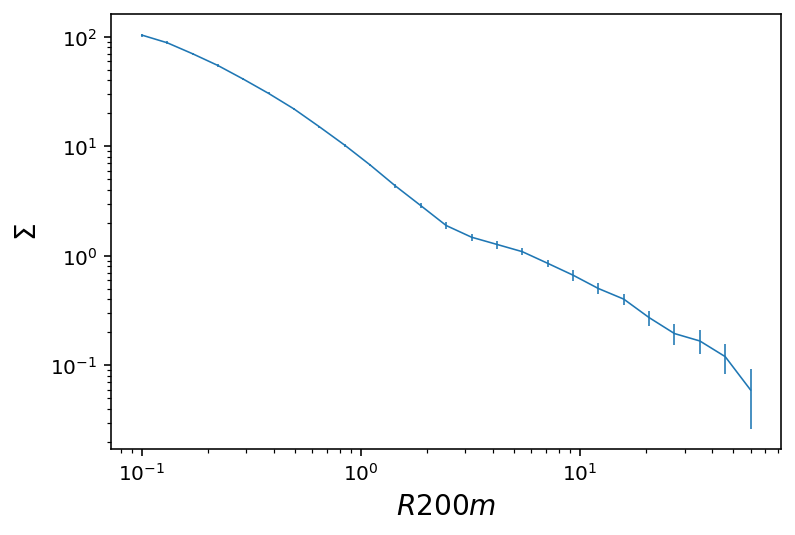

In [3]:
def log_ax(ax):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$\rho$", fontsize=14)
    ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)    

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$\Sigma$", fontsize=14)
ax.set_xlabel(r"$R200m$", fontsize=14)
ax.errorbar(rbin, sigma, yerr = np.sqrt(np.diag(cov)), linewidth = 0.8)


##### **Fit the galaxy density profiles**

Now we can fit the profiles and estimate the splashback radii. All we need to do is run the fit_profs.fit_DK_14 function with the profiles as input. The input for this function is a tuple of the form (r, rho, cov) so we define a function get_data_vec to format our measured profiles so that they are accepted by the fit_profs_fit_DK_14 function. The fitting function can save the output if a save directory is specified. In this case we do not save the output and instead analyze it in this notebook. 

You will also need to specify a `basepath` for Multinest to run the sampler. I have specified this as `/u/samgolds/lib/splashback_tools/splashback_tools/multinest_samples`, but it will need to be changed to a directory on the computer you are working on.

The output of the fit is an $11 \times N$ dimensional array where $N$ is the number of multinest samples (multinest determines this based on convergence criterion). The first 9 columns are the DK14 model parameters. The 10th column is the weights and the 11th is the negative log likelihood. So to find the best fit we find the sample with minimum negative log likelihood. In practice we should run a dedicated minimizer afterwards, but this is good enough for now.

In [ ]:
from splashback_tools.profiles.mc_chain import McChain

# Lambda expression to reformat profiles to input expected by fit_DK_14 function
basepath = '/home/liunicholas6/projects/miscentered-clusters/splashback_tools/multinest_samples'
data_vec = (rbin, sigma, cov)
fit = fit_profs.fit_profile(data_vec, basepath, is_2d = True)
theta = fit[0:9].T
loglikes = fit[-1]
weights = fit[-2]
chain = McChain(weights, loglikes, theta = theta)

Fitting profiles with multinest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    9
 *****************************************************


# Plot Galaxy Profiles with Best Fit

In [ ]:
# Get maximum likelihood
for mbin in mbins:
    chain = mbin['chain']
    mbin['mle'] = chain.samples['theta'][np.argmin(chain.loglikes)]

##### **Plot the galaxy density profiles with the bestfit**

Check if the fits worked

In [ ]:
r_thr = np.logspace(-1, np.log10(7), 100)

fig, axs = plt.subplots(1, n_mbin)
fig.set_size_inches(15,4.5)

for ax, mbin in zip(axs, mbins):
    prof = mbin['prof']

    #Plot profile
    ax.errorbar(prof['r'], prof['rho'], yerr = np.sqrt(np.diag(prof['cov'])), color = 'r', linewidth = 0.8)

    #Set axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$\rho$", fontsize=14)
    ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)
    
    #Plot theory curves
    ax.plot(r_thr, fit_d22.rho(mbin['mle'], r_thr), color='k', linewidth=0.7)

axs[0].text(0.03, 0.05, r"13$<\log_{10}(M_{200m})<$13.5",  
            transform=axs[0].transAxes, fontsize=13)
axs[1].text(0.03, 0.05, r"13.5$<\log_{10}(M_{200m})<$14",  
            transform=axs[1].transAxes, fontsize=13)
axs[2].text(0.03, 0.05, r"14$<\log_{10}(M_{200m})<$14.5",  
            transform=axs[2].transAxes, fontsize=13)

plt.tight_layout()

##### **Determine splashback posterior**

We can then determine the splashback radius by looping through the samples in the chain and determining the location of minimum log derivative for each sample. I will only do this for one of the cluster mass bins for now

In [ ]:
from tqdm import tqdm
import os
import joblib

if 'OMP_NUM_THREADS' in os.environ.keys():
    n_threads = int(os.environ['OMP_NUM_THREADS'])
else:
    n_threads = os.cpu_count()
    
r_log_deriv = np.logspace(-1, np.log10(7), 26)

for mbin in mbins:
    chain = mbin['chain']
    samps = chain.samples['theta']
    n = chain.n_samp

    def get_log_derivs(ind):
        samp = samps[ind]
        return fit_d22.log_deriv_d22(samp, r_log_deriv)
        
    def get_rsps(ind):
        samp = samps[ind]
        return fit_d22.get_rsp(samp)
    
    
    log_deriv = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_log_derivs)(i)
                                           for i in tqdm(range(n))))
    
    rsp = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_rsps)(i)
                                           for i in tqdm(range(n))))
    
    chain.add_samps(log_deriv = log_deriv, rsp = rsp)

##### **Plot splashback posterior**

In [ ]:
ax = plt.gca()
for i, mbin in enumerate(mbins):
    mbin['chain'].plot_1d_posterior('rsp', ax, label = mbin['bounds'])

##### **Plot constraints on logarithmic derivative**

In [ ]:
from scipy.interpolate import CubicSpline

def plot_log_deriv_processed(ax, chain, r_log_deriv, r_thr):
    """
    Plot smoothed density curve of splashback posterior
    """
    
    # Get 1 sigma interval on the derived chains
    
    lower_pts, upper_pts = chain.confidence_interval('log_deriv')
    
    lower_spline = CubicSpline(r_log_deriv, lower_pts)
    upper_spline = CubicSpline(r_log_deriv, upper_pts)
    
    ax.fill_between(r_thr, lower_spline(r_thr), upper_spline(r_thr), alpha=0.5)
    ax.set_xscale('log')

# Initialize Figure   
fig, ax_arr = plt.subplots(1, n_mbin)
fig.set_size_inches(12, n_mbin)

# Plot subplots and set axis label
r_thr = np.logspace(-1, np.log10(5), 100)

for i, mbin in enumerate(mbins):
    ax = ax_arr[i]
    ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)
    ax.set_ylabel(r"$d\log\rho/d\log r$", fontsize=14)
    
    plot_log_deriv_processed(ax, mbin['chain'], r_log_deriv, r_thr)
    

plt.tight_layout()
    

# Splashback Mass

Code creating a chain of msps for every cluster - splashback posterior sample combination (takes very long to run)

In [ ]:
# from colossus.halo import profile_diemer22, concentration
# from colossus.cosmology import cosmology
# cosmology.setCosmology('planck18')

# def get_msp_posterior(mbin):
#     clusters = mbin['clusters']
#     n_clusters = len(clusters['R200m'])
#     chain = mbin['chain']
    
#     def get_msps(ind):
#         M200m = clusters['M200m'][ind]
#         cosmology.setCosmology('planck18')
#         c, _ = concentration.modelBhattacharya13(M200m, redshift, mdef = '200m')
#         prof = profile_diemer22.ModelAProfile(M = M200m, c = c, mdef = '200m', z = redshift)
        
#         R200m = clusters['R200m'][ind]
#         rsp = chain.samples['rsp'] * R200m * 1000
#         return np.array([prof.enclosedMass(rsp_i) for rsp_i in rsp])
    
#     msps = np.concatenate(np.array(joblib.Parallel(n_threads)(joblib.delayed(get_msps)(i)
#                                            for i in tqdm(range(n_clusters)))))
    
#     weights = np.tile(chain.weights, n_clusters)/n_clusters
#     return McChain(weights = weights, msps = msps)

# for mbin in mbins:
#     mbin['msp_chain'] = get_msp_posterior(mbin)

Code calculating the msp for every splashback posterior sample with the average M200m and R200m of the mass bin

In [ ]:
from colossus.halo import profile_diemer22, concentration
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

def get_msp_posterior(mbin):
    clusters = mbin['clusters']
    
    #Generate profile
    M200m = np.mean(clusters['M200m'])
    c, _ = concentration.modelBhattacharya13(M200m, redshift, mdef = '200m')
    prof = profile_diemer22.ModelAProfile(M = M200m, c = c, mdef = '200m', z = redshift)
    
    #Get splashback mass and add to chain
    chain = mbin['chain']
    R200m = np.mean(clusters['R200m'])
    rsp = chain.samples['rsp'] * R200m * 1000
    masses = np.array([prof.enclosedMass(rsp_i) for rsp_i in rsp])
    chain.add_samps(mass = masses)
    return masses

for mbin in mbins:
    get_msp_posterior(mbin)

# def msp_post_estimate(mass_fn, label, mbin):
#     R200m = np.average(mbin['clusters']['R200m'])
#     chain = mbin['chain']
#     rsp = chain.samples['rsp'] * R200m * 1000
#     alpha = 10**chain.samples['theta'][:, 0]
#     log_msp = np.log10(np.array([mass_fn(rsp[i], alpha[i], redshift) for i in range(chain.n_samp)]))
#     chain.add_samps(**{label: log_msp})
#     return log_msp

# def estimate(Rsp, alpha, z):
#     if alpha < 0.155:
#         return float("nan")
#     return calc_mass.Method1(Rsp, alpha, z)

# ax = plt.gca()
# for i, mbin in enumerate(mbins):
#     msp_post_estimate(estimate, 'log_msp_estimate', mbin)
#     mbin['chain'].plot_1d_posterior('log_msp_estimate', ax, label = mbin['bounds'])
    

## Plot Splashback Mass Posteriors

In [ ]:
ax = plt.gca()
for mbin in mbins:
    chain = mbin['chain']
    chain.add_samps(log_mass = np.log10(chain.samples['mass']))
    chain.plot_1d_posterior('log_mass', ax, label = mbin['bounds'])
ax.set_xlabel("log Splashback Mass")

In [ ]:
x = []
y = []
xerr = []
yerr = []
ax = plt.gca()
for mbin in mbins:
    R200m = np.mean(mbin['clusters']['R200m'])
    chain = mbin['chain']
    mu_rsp, sigma_rsp = chain.get_samp_stats('rsp')
    mu_mass, sigma_mass = chain.get_samp_stats('mass')
    x.append(mu_rsp * R200m)
    y.append(mu_mass)
    xerr.append(sigma_rsp * R200m)
    yerr.append(sigma_mass)
ax.errorbar(x = x, y = y, xerr = xerr, yerr = yerr)
ax.set_xlabel("Splashback Radius")
ax.set_ylabel("Splashback Mass")

In [ ]:
import pickle

In [ ]:
np.save('rsp', x)
np.save('msp', y)
np.save('rsp_err', xerr)
np.save('msp_err', yerr)